<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP_FINAL/TP_FINAL_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import zipfile
import io

In [2]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1i0LeTjgW0AK_YDk1wdhzwXdD10AS2xNy',
                                    dest_path='./Colab Notebooks/archive.zip',
                                    unzip=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

ruta_entre = "/content/drive/MyDrive/Colab Notebooks/chest_xray/test/NORMAL"
ruta_entre2 = "/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA"

In [5]:
normal = []
img_size = 50
for img in os.listdir(ruta_entre):
  img = cv2.imread(os.path.join(ruta_entre, img))
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray_resize = cv2.resize(img_gray,(img_size,img_size))
  normal.append([img_gray_resize])



In [6]:
normal = np.array(normal)
print(normal.shape)

(234, 1, 50, 50)


In [7]:
neumonia = []
img_size = 50
for img2 in os.listdir(ruta_entre2):
  img2 = cv2.imread(os.path.join(ruta_entre2, img2))
  img_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  img2_gray_resize = cv2.resize(img_gray,(img_size,img_size))
  neumonia.append([img2_gray_resize])

print(len(neumonia))
neumonia = np.array(neumonia)
print(neumonia.shape)

390
(390, 1, 50, 50)


In [8]:
etiquetas_normal = np.repeat(0, 234)
print(len(etiquetas_normal))

etiquetas_neumonia = np.repeat(1, 390)
print(len(etiquetas_neumonia))

234
390


In [9]:
class_names = ['Normal', 'Neumonia']

In [10]:
rayos_x = np.concatenate([normal,neumonia])
rayos_x = np.array(rayos_x)
print(rayos_x.shape)
labels = np.concatenate([etiquetas_normal,etiquetas_neumonia])
labels = np.array(labels)

(624, 1, 50, 50)


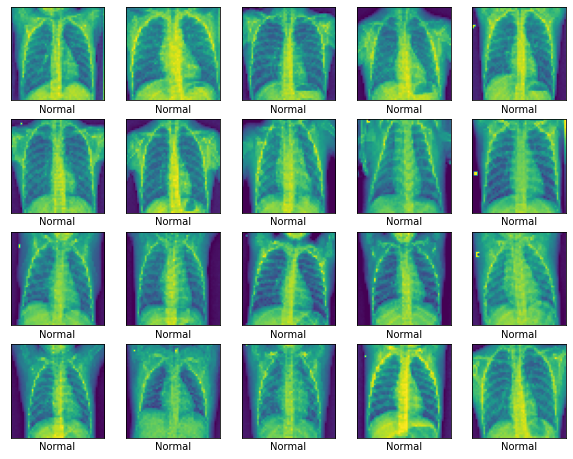

In [11]:
plt.figure(figsize=(10,10))
for i in range (20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(rayos_x[i]))
  plt.xlabel(class_names[labels[i]])
plt.show()

In [12]:
import tensorflow as tf

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

variable_name = ""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import tensorflow.keras.optimizers as Optimizer

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 50, 50, 1)),
    keras.layers.Dense(128, activation='relu'),
    
    keras.layers.Dense(2, activation='softmax'),
    
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(rayos_x, labels, epochs=30)
trained=model.fit(rayos_x, labels, epochs=30)

Epoch 1/30
20/20 [==============================] - 1s 4ms/step - loss: 249.8905 - accuracy: 0.5208
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 14.0430 - accuracy: 0.6298
Epoch 3/30
20/20 [==============================] - 0s 5ms/step - loss: 3.5359 - accuracy: 0.8013
Epoch 4/30
20/20 [==============================] - 0s 4ms/step - loss: 3.7130 - accuracy: 0.7949
Epoch 5/30
20/20 [==============================] - 0s 4ms/step - loss: 3.0866 - accuracy: 0.8077
Epoch 6/30
20/20 [==============================] - 0s 4ms/step - loss: 1.6208 - accuracy: 0.8750
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 2.4353 - accuracy: 0.8269
Epoch 8/30
20/20 [==============================] - 0s 4ms/step - loss: 1.3146 - accuracy: 0.8686
Epoch 9/30
20/20 [==============================] - 0s 4ms/step - loss: 3.0177 - accuracy: 0.8221
Epoch 10/30
20/20 [==============================] - 0s 4ms/step - loss: 1.9301 - accuracy: 0.8494
Epoch 11/30
20/2

--------------------

In [1]:
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import cv2

In [2]:
datos, metadatos = tfds.load('beans', as_supervised=True, with_info=True)
datos

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'validation': <PrefetchDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [3]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [4]:
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui se pasa de 0-255 a 0-1
  #magenes = cv2.cvtColor(imagenes, cv2.COLOR_BGR2GRAY)
  #imagenes = cv2.resize(imagenes,(28,28))
  return imagenes, etiquetas


In [5]:
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

In [6]:
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

In [7]:
clases = ['angular_leaf_spot', 'bean_rust', 'good']

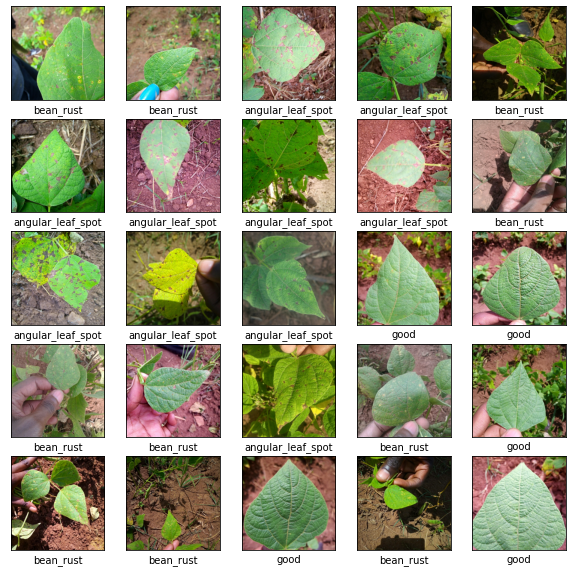

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(clases[etiqueta])

plt.show()  

In [9]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(500,500,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), #2,2 es el tamano de la matriz

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [11]:
num_datos_entrenamiento = metadatos.splits["train"].num_examples
num_datos_pruebas = metadatos.splits["test"].num_examples

#Trabajar por lotes
TAMANO_LOTE=32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria
#para que el entrenamiento no se aprenda las cosas en orden
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_datos_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
#Realizar el entrenamiento
import math

historial = modelo.fit(
    datos_entrenamiento,
    epochs=60,
    steps_per_epoch=math.ceil(num_datos_entrenamiento/TAMANO_LOTE)
)

Epoch 1/60
33/33 [==============================] - 357s 11s/step - loss: 6.1171 - accuracy: 0.4233
Epoch 2/60
33/33 [==============================] - 353s 11s/step - loss: 0.7396 - accuracy: 0.7178
Epoch 3/60
33/33 [==============================] - 353s 11s/step - loss: 0.4098 - accuracy: 0.8485
Epoch 4/60
33/33 [==============================] - 359s 11s/step - loss: 0.2591 - accuracy: 0.9233
Epoch 5/60
33/33 [==============================] - 352s 11s/step - loss: 0.0936 - accuracy: 0.9801
Epoch 6/60
33/33 [==============================] - 346s 10s/step - loss: 0.0302 - accuracy: 0.9943
Epoch 7/60
33/33 [==============================] - 354s 11s/step - loss: 0.0077 - accuracy: 0.9991
Epoch 8/60
33/33 [==============================] - 348s 11s/step - loss: 0.0064 - accuracy: 0.9981
Epoch 9/60
33/33 [==============================] - 352s 11s/step - loss: 0.0087 - accuracy: 1.0000
Epoch 10/60
33/33 [==============================] - 347s 11s/step - loss: 0.0022 - accuracy: 1.0000